In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from facenet_pytorch import InceptionResnetV1

In [ ]:
mdl = InceptionResnetV1(pretrained='vggface2', num_classes=2, classify=True)
print(mdl)

  0%|          | 0.00/107M [00:00<?, ?B/s]

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

Training Data

In [ ]:
import pandas as pd
from glob import glob #for finding files recursively
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

NEW TRAINING DATA CODE

In [ ]:
relationshipsCSV = "/content/drive/MyDrive/recognizing-faces-in-the-wild/train_relationships.csv"
train_images_folder = "/content/drive/MyDrive/recognizing-faces-in-the-wild/train/"

In [ ]:
available_images = glob(train_images_folder + "*/*/*.jpg")

In [ ]:
all_ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in available_images] #all the people

In [ ]:
#creating the training set
personPathFile = defaultdict(list)
for x in available_images:
    personPathFile[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#read from the csv to create a list of tuples
relationships = pd.read_csv(relationshipsCSV)
relationship_pairs = [(row['p1'], row['p2']) for index, row in relationships.iterrows()] # Create a list of tuples
relationship_pairs = [x for x in relationship_pairs if x[0] in all_ppl and x[1] in all_ppl] #data cleaning

#converting into dictionary of person is related to this list of people
relationshipDict = defaultdict(list)
for item in relationship_pairs:
  relationshipDict[item[0]].append(item[1]) #you do not need to consider the item[1] because the CSV is already pretty clean


#create more data by finding the 'negative pair'
notRelationshipDict = defaultdict(list)
set_all_ppl = set(all_ppl)
#for each key(person) in the relationship dictionary, find the non-relations
for k,v in relationshipDict.items():
    notRelationshipDict[k]=list(set_all_ppl-set(v))



# convert both dictionaries into a list of tuples with 1, 0 as labels
# for each of the image, take the first image path stored in the dictionary made earlier
# then take each of the path file in the item

trainData = []
for k,v in relationshipDict.items():
    for relation in v:
        for item in personPathFile[k]:
          for item2 in personPathFile[relation]:
                trainData.append((item, item2,1))


positiveRelationsCount = len(trainData)
print("Current Length of positive relationships: ", len(trainData))
for k,v in notRelationshipDict.items():
    for Notrelation in v:
        for item in personPathFile[k]:
          for item2 in personPathFile[Notrelation]:
                trainData.append((item, item2,0))
    if len(trainData)>=positiveRelationsCount*2:
      break

Current Length of positive relationships:  165179


In [ ]:
#Checking whether the trainData is created correctly
print("Total Length of all relationships: ", len(trainData))
print(trainData[:100]) #print the first 100

Total Length of all relationships:  400228
[('/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID1/P00016_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID3/P00010_face1.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID1/P00016_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID3/P00018_face2.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID1/P00016_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID3/P00011_face3.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID1/P00016_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID3/P00009_face1.jpg', 1), ('/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID1/P00016_face2.jpg', '/content/drive/MyDrive/recognizing-faces-in-the-wild/train/F0002/MID3/P00017_face1.jpg', 1), ('/content/drive/MyDrive/recogn

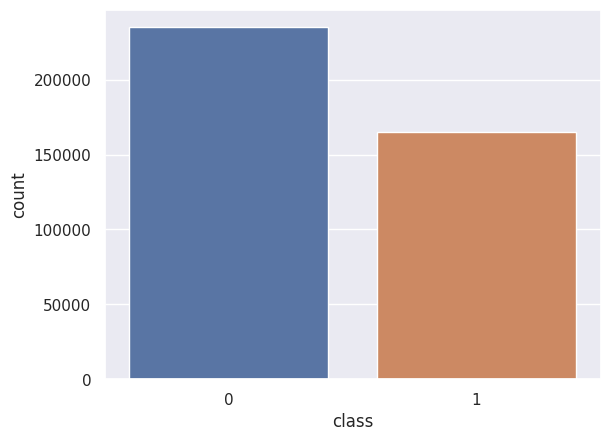

In [ ]:
#checking the balance of positive and negative data
dfTrainData = pd.DataFrame (trainData, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [ ]:
#use the pytorch built in Dataset function
class trainingDataset(Dataset):
    def __init__(self, _data, _transform=None):
        self.data = _data #choose either train or val dataset to use
        self.transform = _transform


    def __getitem__(self,index):

        first_img_path = self.data[index][0]
        second_img_path = self.data[index][1]
        img1Opened = Image.open(first_img_path)
        img2Opened = Image.open(second_img_path)


        #it is important to transform the images into tensor format
        if self.transform is not None:
            img1Opened = self.transform(img1Opened)
            img2Opened = self.transform(img2Opened)
        return img1Opened, img2Opened , self.data[index][2]

    def __len__(self):
        return len(self.data)#essential for choose the num of data in one epoch

In [ ]:
from sklearn.model_selection import train_test_split
BATCH_SIZE=128
IMG_SIZE=100
NUM_WORKERS = 8


trainSet, valSet = train_test_split(trainData, test_size=0.5, random_state=42)
#TODO: Normalize the data

#Training set and training loader
trainset = trainingDataset(_data=trainSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

valset = trainingDataset(_data=valSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))



trainloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)


valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Siamese Model

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained_model):
        super(SiameseNetwork, self).__init__()
        self.model = pretrained_model  # Load your pre-trained model

    def forward_one(self, x):
        return self.model(x)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

Finetune Model

In [ ]:
from PIL import Image

In [ ]:
import numpy as np


# Create the Siamese network
siamese_net = SiameseNetwork(mdl).cuda()

# Define the contrastive loss
criterion = ContrastiveLoss()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

counter = []
iteration_number= 0

# BATCH_SIZE=128
NUMBER_EPOCHS=10
epoch_accuracies = np.array([])

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch)
    for i, data in enumerate(trainloader,0):

        img0, img1 , labels = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
        optimizer.zero_grad()
        outputs = siamese_net(img0,img1)
        # loss = criterion(outputs,labels)
        loss = criterion(outputs[0], outputs[1], labels) #Check
        loss.backward()
        optimizer.step()
        # if i == 3: #for testing
        #   break #for testing

    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = siamese_net(img0,img1)
            _, predicted = torch.max(outputs[0].data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            # break #for testing

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)
    print(f"Epoch [{epoch+1}/{NUMBER_EPOCHS}] Accuracy: {accuracy}")

best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch, ' WITH ACCURACY: ', best_accuracy)

torch.save(siamese_net, 'resulting_siamese_model.pth')

Epoch： 0
Epoch [1/10] Accuracy: 45.39112705757718
Epoch： 1
Epoch [2/10] Accuracy: 65.28478767102752
Epoch： 2
Epoch [3/10] Accuracy: 37.399182465994386
Epoch： 3
Epoch [4/10] Accuracy: 35.23691495847367
Epoch： 4


OSError: ignored

TEST LOOP

In [ ]:
# !unzip '/content/drive/MyDrive/recognizing-faces-in-the-wild/test.zip' -d '/content/drive/MyDrive/recognizing-faces-in-the-wild/test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face04688.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face03972.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face02593.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face00836.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face05284.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face03261.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face00582.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face02696.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face05325.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face04973.jpg  
  inflating: /content/drive/MyDrive/recognizing-faces-in-the-wild/test/face0290

In [ ]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv

    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/drive/MyDrive/recognizing-faces-in-the-wild/sample_submission.csv')
        self.transform = transform

    def __getitem__(self,index):

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]

        img0 = Image.open('test/'+img0_path)
        img1 = Image.open('test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)


In [ ]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=128)#Both extra workers and batch size lead to data out of order, the submission.csv

In [ ]:
%cd '/content/drive/MyDrive/recognizing-faces-in-the-wild/'

/content/drive/MyDrive/recognizing-faces-in-the-wild


In [ ]:
#Testing impiega circa 1 minuto (per Naive) e circa 5 minuti (per reti preaddestrate)
test_df = pd.read_csv('/content/drive/MyDrive/recognizing-faces-in-the-wild/sample_submission.csv')
predictions=[]

with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        output1, output2 = siamese_net(img0,img1)
        _, predicted = torch.max(output1, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)


test_df['is_related'] = predictions
test_df.to_csv("test_Results.csv", index=False) #submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed